# 3.5 Read write binary files

Since Spark 3.0, Spark supports binary file data source, which reads binary files and converts each file into a single record that contains the raw content and metadata of the file. It produces a DataFrame with the following columns and possibly partition columns:

- path: StringType
- modificationTime: TimestampType
- length: LongType
- content: BinaryType


To read whole binary files, you need to specify the data source format as binaryFile. To load files with paths matching a given glob pattern while keeping the behavior of partition discovery, you can use the general data source option pathGlobFilter. For example, the following code reads all PNG files from the input directory:

In [1]:
from pyspark.sql import SparkSession
from PIL import Image
import io
import os

In [2]:
local=True
if local:
    spark=SparkSession.builder.master("local[4]") \
                  .appName("ReadWriteBinary").getOrCreate()
else:
    spark=SparkSession.builder \
                      .master("k8s://https://kubernetes.default.svc:443") \
                      .appName("ReadWriteBinary") \
                      .config("spark.kubernetes.container.image",os.environ["IMAGE_NAME"]) \
                      .config("spark.kubernetes.authenticate.driver.serviceAccountName",os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
                      .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
                      .config("spark.executor.instances", "4") \
                      .config("spark.executor.memory","8g") \
                      .config("spark.kubernetes.driver.pod.name", os.environ["POD_NAME"]) \
                      .config('spark.jars.packages','org.postgresql:postgresql:42.2.24') \
                      .getOrCreate()

22/02/15 16:27:06 WARN Utils: Your hostname, pliu-SATELLITE-P850 resolves to a loopback address: 127.0.1.1; using 172.22.0.33 instead (on interface wlp3s0)
22/02/15 16:27:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/15 16:27:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# render image byte in jupyter
def render_image(image_bytes_list):
    for image_bytes in image_bytes_list:
        image=Image.open(io.BytesIO(image_bytes))
        display(image)

In [4]:
image_input_folder_path="data/binary"

In [5]:
image_schema = spark.read.format("binaryFile").load(image_input_folder_path).schema
raw_image_df = spark.read \
        .format("binaryFile") \
        .option("maxFilesPerTrigger", "500") \
        .option("recursiveFileLookup", "true") \
        .option("pathGlobFilter", "*.png") \
        .schema(image_schema) \
        .load(image_input_folder_path)
raw_image_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/pliu/P...|2022-02-15 16:19:...|329899|[89 50 4E 47 0D 0...|
|file:/home/pliu/P...|2022-02-15 16:23:...|225594|[89 50 4E 47 0D 0...|
+--------------------+--------------------+------+--------------------+



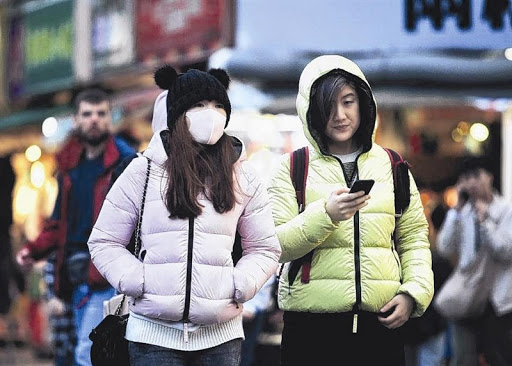

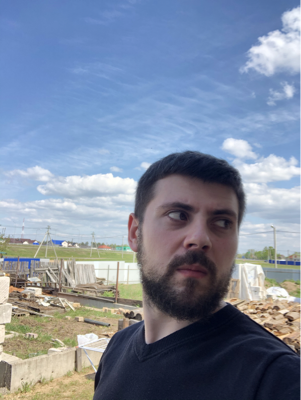

In [6]:
# show the origin image
origin_col_name="content"
origin_image_list = raw_image_df.select(origin_col_name).toPandas()[origin_col_name]
render_image(origin_image_list)